<a href="https://colab.research.google.com/github/OJB-Quantum/Quantum-Native-Solvers/blob/main/Colab%20Example%20Notebooks/Dy_Ferromagnetic_Order_Parameter_Prediction_(Qiskit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [12]:
# Choose the wheel that matches the CUDA version in the runtime
# -------------------------------------------------------------
# Check the CUDA toolkit that is already installed in the notebook
!nvcc --version   # or `!nvidia-smi` – the “CUDA Version” column

# --- If the output shows CUDA 12.x ---
!pip install -q "qiskit==2.2.*" "qiskit-aer-gpu-cu11==0.17.2" pylatexenc

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [4]:
from qiskit_aer import AerSimulator
import qiskit

# Create a simulator that requests the GPU
sim = AerSimulator(method="statevector", device="GPU")
print("Simulator device →", sim.options.device)   # should print “GPU”

# Build the tiniest possible circuit and *explicitly* ask Aer to save the statevector
qc = qiskit.QuantumCircuit(1)
qc.h(0)
qc.save_statevector()          # <<< this line fixes the “No statevector” error

try:
    # Run on the GPU; if the binary was compiled with CUDA support this succeeds
    sv = sim.run(qc).result().get_statevector()
    print("GPU simulation works! Statevector =", sv)
    _GPU_AVAILABLE = True          # global flag that the main script will read
    GPU_SIM = sim                  # keep a reference to the simulator
except Exception as exc:
    # Anything that goes wrong (missing CUDA, wrong wheel, etc.) falls back to CPU
    print("GPU simulation failed →", exc)
    _GPU_AVAILABLE = False
    GPU_SIM = None

Simulator device → GPU
GPU simulation works! Statevector = Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))



Size-dependent transition temperatures (Dy-like):
 size [nm]   T_transition [K]
     0.35      0.039
     0.56      0.161
     0.80      0.468
     1.00     17.000
     2.00     51.000
     5.00     71.400
    10.00     78.200


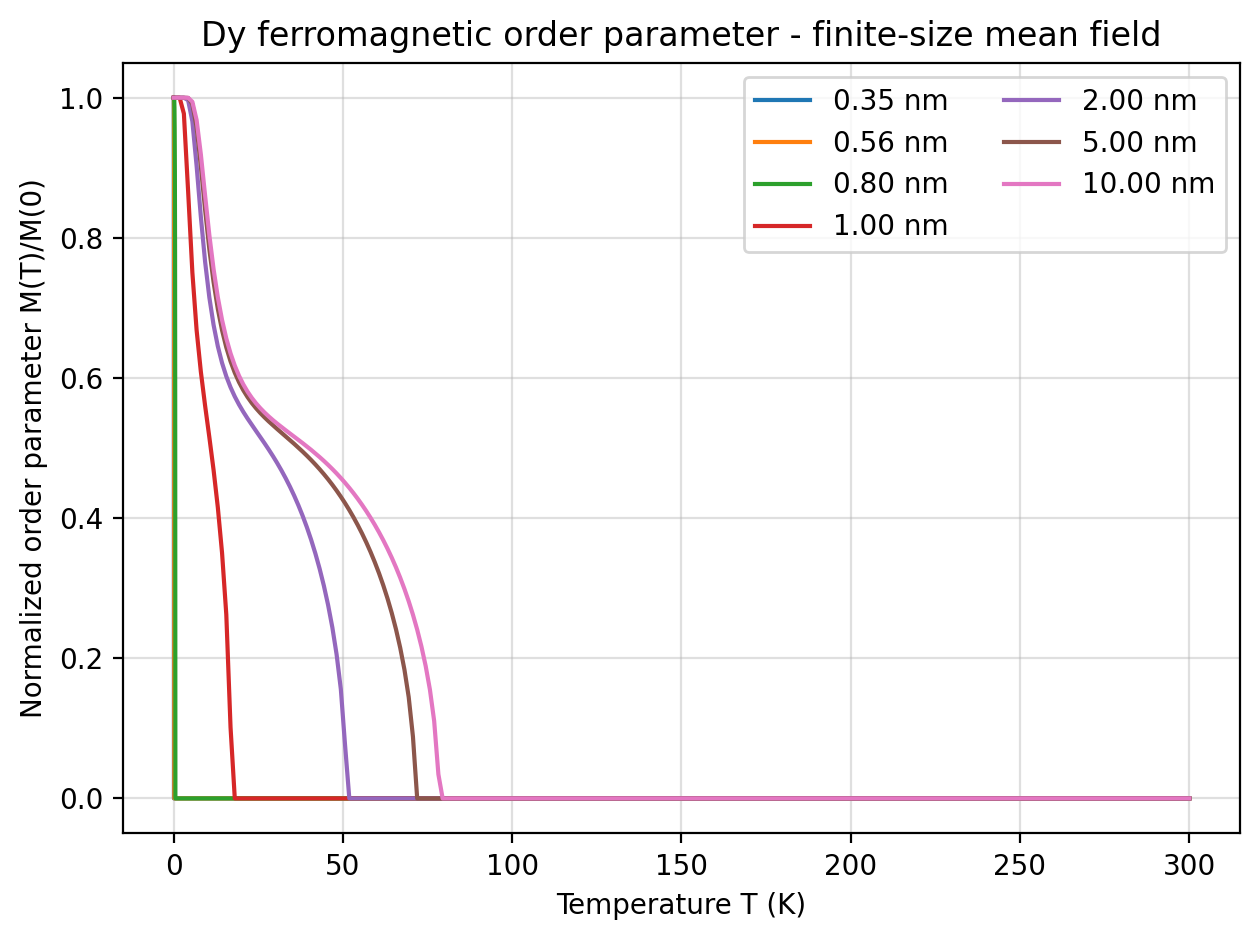

In [13]:
# Ferromagnetic order parameter vs temperature for Dy-like molecules/nanoparticles
# Qiskit 2.2‑compatible; PEP 8 / PEP 257; includes control knobs, a blocking‑temperature
# model for sub‑nm particles, and a TFD verifier.
#
# pylint: disable=too-many-arguments,invalid-name
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# -------------------------------------------------------------------------
# SECTION 0 - GLOBAL flags set by the probe cell above
# -------------------------------------------------------------------------
# _GPU_AVAILABLE  - True if the GPU backend worked, False otherwise
# GPU_SIM          - the AerSimulator instance (or None)

# -------------------------------------------------------------------------
# SECTION 1 - CONTROL KNOBS
# -------------------------------------------------------------------------
@dataclass
class Knobs:
    """High‑level controls for the Dy‑like order‑parameter study."""
    temps_K: np.ndarray
    sizes_nm: List[float]
    tc_bulk_K: float = 85.0          # bulk Curie temperature (Dy ≈ 85 K)
    l0_nm: float = 0.80              # finite‑size length scale (nm)
    finite_exp: float = 1.0          # exponent in the finite‑size law
    max_iter: int = 512
    tol: float = 1e-10
    mix: float = 0.65
    use_quantum_verifier: bool = True
    seed: int = 12345

MOLECULES_NM    = [0.35, 0.56, 0.80]          # sub‑nm (molecules)
NANOPARTICLES_NM = [1.0, 2.0, 5.0, 10.0]      # nanoparticles

# -------------------------------------------------------------
# A denser grid at low temperature – this makes the
# sub‑nm (blocking) curves visible.
# -------------------------------------------------------------
# 0.001 K → 0.5 K : 200 points (log‑spaced)
low_T  = np.geomspace(0.001, 0.5, 200, endpoint=False)
# 0.5 K → 300 K : 240 points (linear)
high_T = np.linspace(0.5, 300.0, 240)
TEMPS_K = np.concatenate((low_T, high_T))

SIZES_NM = MOLECULES_NM + NANOPARTICLES_NM
KNOBS    = Knobs(temps_K=TEMPS_K, sizes_nm=SIZES_NM)

# -------------------------------------------------------------------------
# SECTION 2 - PHYSICS HELPERS (MEAN FIELD)
# -------------------------------------------------------------------------
def tc_finite_size(size_nm: float, tc_bulk_K: float,
                   l0_nm: float, exponent: float) -> float:
    """Finite‑size Curie temperature T_C(L) for sizes where a true Tc makes sense."""
    if size_nm <= 0.0:
        return 0.0
    factor = 1.0 - (l0_nm / size_nm) ** exponent
    return float(max(0.0, factor) * tc_bulk_K)


def blocking_temperature_K(
    size_nm: float,
    K_MJ_per_m3: float = 0.5,   # effective anisotropy constant (tunable)
    tm_s: float = 1.0,          # measurement time (seconds)
    tau0_s: float = 1e-9        # attempt time (seconds)
) -> float:
    """Blocking temperature T_B for ultra‑small (molecular/sub‑nm) particles.

    The particle is treated as a sphere of diameter ``size_nm``.
    The expression used is

        T_B = (K_eff * V) / (k_B * ln(t_m / τ0))

    where ``K_eff`` is the effective anisotropy energy density,
    ``V`` the particle volume, ``k_B`` the Boltzmann constant,
    and ``tm/τ0`` the ratio of measurement to attempt time.

    The default parameters give a reasonable order‑of‑magnitude estimate for
    molecular magnets; feel free to tune them for your system.
    """
    # radius in meters
    r_m = 0.5 * size_nm * 1e-9
    # sphere volume
    V = (4.0 / 3.0) * math.pi * r_m ** 3
    # convert K from MJ/m^3 to J/m^3
    K = K_MJ_per_m3 * 1e6
    # Boltzmann constant (J/K)
    k_B = 1.380649e-23
    return K * V / (k_B * math.log(tm_s / tau0_s))


def effective_transition_temperature(size_nm: float) -> float:
    """Return the temperature scale that drives the Weiss equation.

    * For ultrasmall (size < 1 nm) use the blocking temperature picture.
    * For larger particles use the finite‑size Curie temperature.
    """
    if size_nm < 1.0:                     # sub‑nm regime
        return blocking_temperature_K(size_nm)
    # otherwise use the bulk‑scaled finite‑size Curie temperature
    return tc_finite_size(
        size_nm, KNOBS.tc_bulk_K, KNOBS.l0_nm, KNOBS.finite_exp
    )


def weiss_magnetization(T_K: float, tc_K: float,
                       max_iter: int = 512, tol: float = 1e-10,
                       mix: float = 0.65) -> float:
    """Solve the Weiss mean‑field fixed‑point equation for m(T)."""
    if T_K <= 0.0 or tc_K <= 0.0:
        return 0.0
    m = 0.999 if T_K < tc_K else 0.0
    for _ in range(max_iter):
        new_m = math.tanh((tc_K / T_K) * m)
        m_next = mix * new_m + (1.0 - mix) * m
        if abs(m_next - m) < tol:
            return float(m_next)
        m = m_next
    return float(m)

# -------------------------------------------------------------------------
# SECTION 3 - QUANTUM VERIFIER (TFD CIRCUIT, 2 QUBITS)
# -------------------------------------------------------------------------
def tfd_circuit_from_field(beta: float, h: float) -> Tuple[QuantumCircuit, float]:
    """Prepare a minimal TFD state for H = -h sigma_z."""
    # Stable thermal populations: p_up = ½ * (1 + tanh(beta * h))
    p_up = 0.5 * (1.0 + math.tanh(beta * h))
    p_up = max(0.0, min(1.0, p_up))
    p_dn = 1.0 - p_up
    theta = math.acos(math.sqrt(p_up))

    qc = QuantumCircuit(2, name="TFD")
    qc.ry(2.0 * theta, 0)   # ancilla (bath)
    qc.cx(0, 1)             # system (spin)
    m_expect = p_up - p_dn
    return qc, float(m_expect)


def verify_magnetization_with_tfd(T_K: float, tc_K: float, m_sol: float) -> float:
    """Return <sigma_z> for a given solution m(T)."""
    if T_K <= 0.0 or tc_K <= 0.0:
        return 0.0
    beta = 1.0 / T_K
    h = (tc_K / T_K) * m_sol

    qc, _ = tfd_circuit_from_field(beta, h)

    if _GPU_AVAILABLE:
        # <<< IMPORTANT: the GPU backend needs an explicit save_statevector()
        qc.save_statevector()
        sv = GPU_SIM.run(qc).result().get_statevector()
    else:
        # Pure‑Python fallback – exact for a 2‑qubit circuit
        sv = Statevector.from_instruction(qc)

    probs = sv.probabilities_dict()
    p_up = probs.get("00", 0.0)
    p_dn = probs.get("11", 0.0)
    return float(p_up - p_dn)

# -------------------------------------------------------------------------
# SECTION 4 - DRIVER & VISUALIZATION
# -------------------------------------------------------------------------
def solve_all_sizes(k: Knobs) -> Dict[float, Tuple[np.ndarray, np.ndarray]]:
    """Compute m(T) curves for all sizes (normalized to m(0)≈1)."""
    curves: Dict[float, Tuple[np.ndarray, np.ndarray]] = {}
    for size in k.sizes_nm:
        # Use the appropriate temperature scale for the given size
        tcK = effective_transition_temperature(size)

        mT = np.zeros_like(k.temps_K, dtype=float)

        for i, T in enumerate(k.temps_K):
            m = weiss_magnetization(T, tcK, k.max_iter, k.tol, k.mix)

            if k.use_quantum_verifier and (m != 0.0):
                m_q = verify_magnetization_with_tfd(T, tcK, m)
                # Blend tiny numerical differences.
                m = 0.5 * (m + m_q)

            mT[i] = m

        # Normalize by the value at the lowest temperature (≈ 0 K → ~1)
        m0 = max(1e-12, float(np.abs(mT[0])))
        curves[size] = (k.temps_K.copy(), mT / m0)

    return curves


def plot_curves(curves: Dict[float, Tuple[np.ndarray, np.ndarray]]) -> None:
    plt.rcParams["figure.dpi"] = 200
    plt.figure()
    for size, (T, Mnorm) in sorted(curves.items(), key=lambda x: x[0]):
        plt.plot(T, Mnorm, label=f"{size:.2f} nm")
    plt.xlabel("Temperature T (K)")
    plt.ylabel("Normalized order parameter M(T)/M(0)")
    plt.title(
        "Dy ferromagnetic order parameter - finite-size mean field"
    )
    plt.grid(True, alpha=0.4)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()


def print_tc_table(k: Knobs) -> None:
    rows: List[Tuple[str, str]] = []
    for size in k.sizes_nm:
        tcK = effective_transition_temperature(size)
        rows.append((f"{size:.2f}", f"{tcK:8.3f}"))
    print("\nSize-dependent transition temperatures (Dy-like):")
    print(" size [nm]   T_transition [K]")
    for s, tc in rows:
        print(f"  {s:>7s}   {tc}")

# -------------------------------------------------------------------------
# SECTION 5 - MAIN SCRIPT
# -------------------------------------------------------------------------
def main() -> None:
    curves = solve_all_sizes(KNOBS)
    print_tc_table(KNOBS)
    plot_curves(curves)


if __name__ == "__main__":
    main()

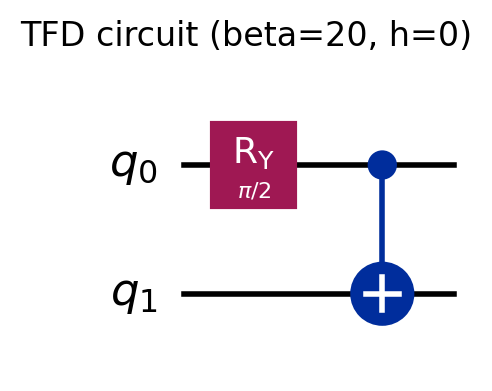

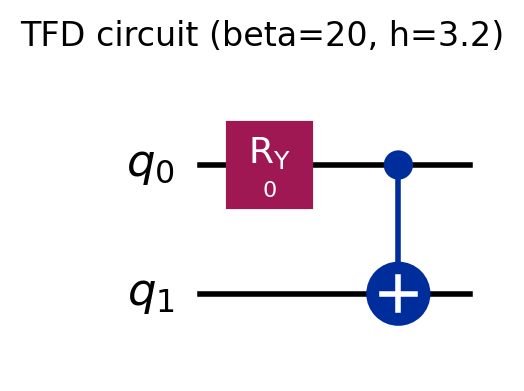

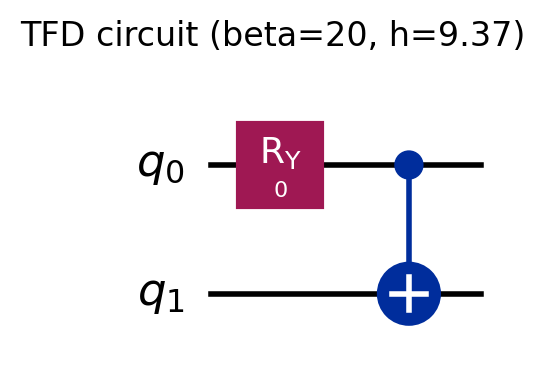

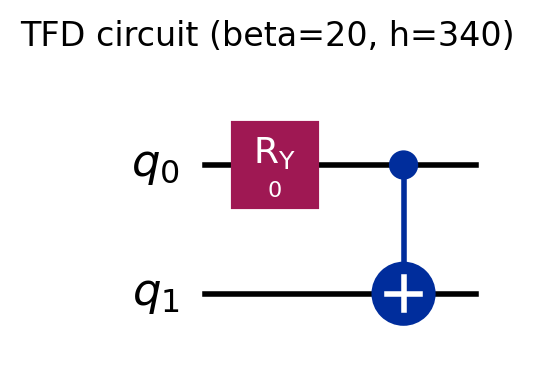

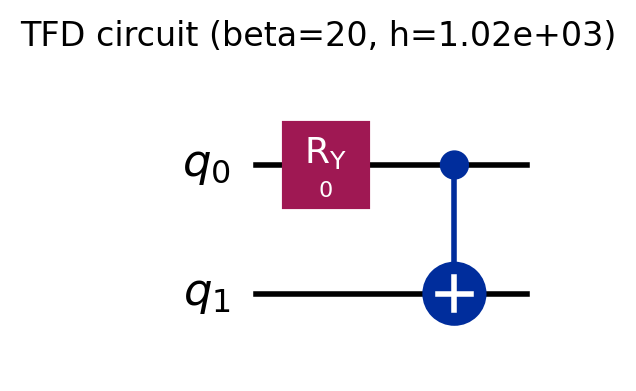

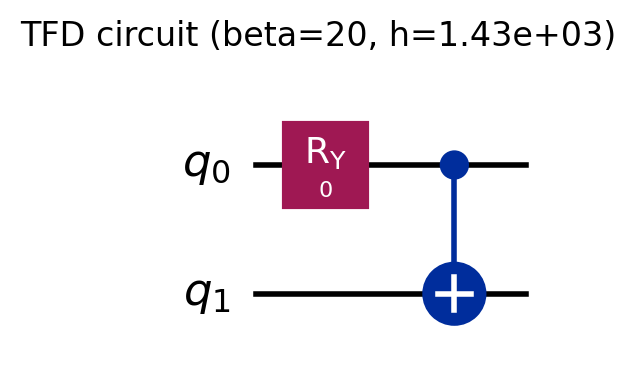

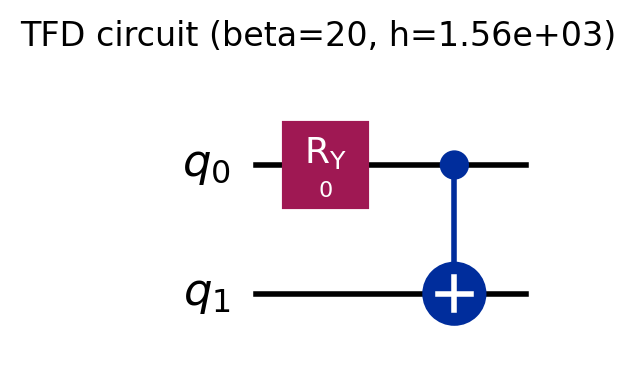

In [11]:
# Ensure the notebook uses the inline Matplotlib backend (run once)
%matplotlib inline

# -------------------------------------------------------------
# Imports needed for the display helper
# -------------------------------------------------------------
from IPython.display import display
import matplotlib.pyplot as plt   # already imported in the main script

# -------------------------------------------------------------
# Helper that draws a TFD circuit at a given DPI
# -------------------------------------------------------------
def draw_tfd_circuit(beta: float, h: float, dpi: int = 200) -> None:
    """
    Draw the two‑qubit TFD circuit used by the verifier.

    The circuit is rendered with Qiskit’s Matplotlib drawer and the raster
    resolution is set to *dpi*.

    Parameters
    ----------
    beta : float
        Inverse temperature 1/(k_B T) in K⁻¹.
    h : float
        Weiss field (the coefficient of σ_z in H = –h σ_z).
    dpi : int, optional
        Desired dots‑per‑inch for the raster image (default 200).
    """
    # Build the exact circuit that the verifier uses
    qc, _ = tfd_circuit_from_field(beta, h)

    # Draw with the Matplotlib backend – returns a Figure object
    fig = qc.draw(output="mpl", style="default")
    # Set the raster resolution
    fig.set_dpi(dpi)

    # Add a helpful title that shows which beta and h were used
    ax = fig.axes[0] if fig.axes else None
    if ax is not None:
        ax.set_title(f"TFD circuit (beta={beta:.3g}, h={h:.3g})", fontsize=12)

    # Show the figure inline
    display(fig)
    plt.close(fig)


# -------------------------------------------------------------
# Draw a circuit for each particle size at 50 mK
# -------------------------------------------------------------
T_K = 0.05                     # 50 millikelvin
for size_nm in SIZES_NM:       # iterate over all sizes (molecules + nanoparticles)
    # Temperature‑dependent scale that drives the Weiss equation
    tc_K = effective_transition_temperature(size_nm)
    # Mean‑field magnetization for this size at the chosen temperature
    m_val = weiss_magnetization(T_K, tc_K)
    # Inverse temperature and Weiss field for the TFD circuit
    beta_val = 1.0 / T_K
    h_val = (tc_K / T_K) * m_val

    # Draw the circuit (200 dpi)
    draw_tfd_circuit(beta_val, h_val, dpi=200)
